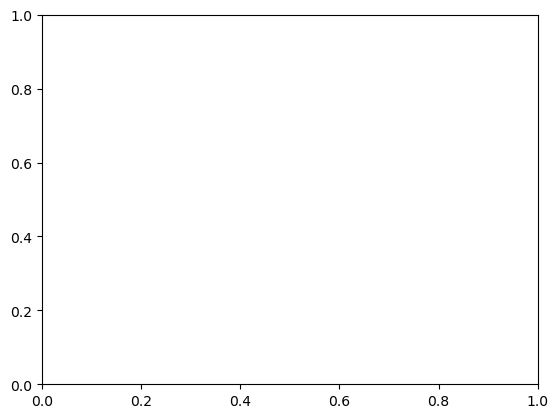

In [1]:
"""
in terminal
# jupyter nbconvert --to script realization2.ipynb
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
# from scipy.interpolate import interp2d, bisplev
from scipy.interpolate import RectBivariateSpline, bisplrep, bisplev, griddata
import glob
import os
import re
from scipy.optimize import curve_fit
import sys
from Definitions import *
import pickle
import numpy as np
import matplotlib.pyplot as plt




data_root = "Data/2025_09_10/"
figure_root = "Figures/"

In [2]:
# Latex support
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",
})
# mpl.style.use("seaborn")
# mpl.rcParams['font.size'] = 18
SMALL_SIZE = 18
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",
})

### definitions

In [3]:


def binned_plot3(data, bin_edges=None, ax=None, color="C0", label=None):
    """
    Plot a binned histogram on a given axes object.
    
    Parameters:
        data      : array-like, the data to bin
        bin_edges: array-like, required bin edges (e.g., np.linspace(...))
        ax       : matplotlib Axes, optional – if None, uses current Axes
        color    : bar color
        label    : legend label
    """
    if bin_edges is None:
        raise ValueError("You must provide fixed bin_edges.")
    
    if ax is None:
        ax = plt.gca()

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Compute histogram
    counts, _ = np.histogram(data, bins=bin_edges)

    # Plot on provided Axes
    ax.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.7,
        label=label
    )


In [4]:

def natural_length(a_x, a_y, m_eff=1.0):
    """
    Compute natural length scales Lx and Ly (in nm) for an anisotropic quantum dot.

    Parameters:
        a_x, a_y : array-like or float
            Confinement curvatures along x and y in eV/nm².
        m_eff : float
            Effective mass in units of electron mass (default: 1.0).

    Returns:
        Lx, Ly : ndarray
            Natural length scales along x and y, in nanometers.
    """
    # Physical constants (SI)
    hbar = 1.0545718e-34      # J·s
    m_e = 9.10938356e-31      # kg
    eV_per_nm2_to_J_per_m2 = 1.60218e-19 * 1e18

    a_x = np.asarray(a_x) * eV_per_nm2_to_J_per_m2
    a_y = np.asarray(a_y) * eV_per_nm2_to_J_per_m2
    m = m_eff * m_e

    Lx = (hbar**2 / (m * a_x))**0.25 * 1e9  # in nm
    Ly = (hbar**2 / (m * a_y))**0.25 * 1e9

    return Lx, Ly


### read DQD parameters (*.pkl files)

In [5]:
"""rho = 10^10 cm-2"""
# with open(data_root+"DQD_rho1e10.pkl", 'rb') as f:
with open(data_root+"DQD_rho1e10_after_tuning.pkl", 'rb') as f:
    data = pickle.load(f)

"""rho = 5x10^9 cm-2"""
# with open(data_root+"DQD_rho5e9.pkl", 'rb') as f:
# with open(data_root+"DQD_rho5e9_after_tuning.pkl", 'rb') as f:
with open(data_root+"DQD_rho1e10_after_tuning.pkl", 'rb') as f:
    data2 = pickle.load(f)


with open(data_root+"pot_params_base.pkl", 'rb') as f:
    base = pickle.load(f)
# Access like:
xLs = data['xLs']


"""convert ax ay to QD dimenstion"""
data["axLs"], data["axRs"] = natural_length(data["axLs"], data["axRs"], m_eff=0.19)
data2["axLs"], data2["axRs"] = natural_length(data2["axLs"], data2["axRs"], m_eff=0.19)
base["axL_0"], base["axR_0"] = natural_length(np.array([base["axL_0"]]), np.array([base["axR_0"]]), m_eff=0.19)
base["axL_0"], base["axR_0"] = base["axL_0"].item(), base["axR_0"].item()

data["ayLs"], data["ayRs"] = natural_length(data["ayLs"], data["ayRs"], m_eff=0.19)
data2["ayLs"], data2["ayRs"] = natural_length(data2["ayLs"], data2["ayRs"], m_eff=0.19)
base["ayL_0"], base["ayR_0"] = natural_length(np.array([base["ayL_0"]]), np.array([base["ayR_0"]]), m_eff=0.19)
base["ayL_0"], base["ayR_0"] = base["ayL_0"].item(), base["ayR_0"].item()


In [6]:
base

{'xL_0': 281.49561254562684,
 'axL_0': 16.941714801528214,
 'EL_0': -0.023954464916139246,
 'xR_0': 378.47068650165306,
 'axR_0': 16.983562891402542,
 'ER_0': -0.023957898919887238,
 'yL_0': 290.9809801525911,
 'ayL_0': 15.609604982758578,
 'yR_0': 291.0079044083388,
 'ayR_0': 15.56528453025077,
 'eps_L_0': -0.022432851815078633,
 'eps_R_0': -0.022435031210562756,
 'Fx_L_0': 99.44124375267441,
 'Fx_R_0': 128.68605234344136,
 'Fy_L_0': 62.71621374503116,
 'Fy_R_0': -73.66320700676376,
 'Fz_L_0': -167066.2015060878,
 'Fz_R_0': -167066.83603550188,
 'EB_0': -0.023056717220857816,
 'Bh_0': 0.000901181699029422,
 'tc_0': 48.31579229167255,
 'Eavg_0': -23000.345786086982,
 'Vac_0': 0.0,
 'd_0': 90.53537658769496}

In [7]:

data['Eavgs'] = data['Eavgs'] * 1e-6
data["FzLs"] = data["FzLs"] * 1e-6
data["FzRs"] = data["FzRs"] * 1e-6
data['eps'] = data['eps'] * 1e3


data2['Eavgs'] = data2['Eavgs'] * 1e-6
data2["FzLs"] = data2["FzLs"] * 1e-6
data2["FzRs"] = data2["FzRs"] * 1e-6
data2['eps'] = data2['eps'] * 1e3

backup

In [8]:
data.update({"Favg": ( data["FzLs"] + data["FzRs"] )/2})
data.update({"dF": (data["FzLs"] - data["FzRs"])})

data.update({"dLx": (data["axLs"] - data["axRs"])})
data.update({"Lxavg": (data["axLs"] + data["axRs"])/2})



data2.update({"Favg": (data2["FzLs"] + data2["FzRs"])/2})
data2.update({"dF": (data2["FzLs"] - data2["FzRs"])})

data2.update({"dLx": (data2["axLs"] - data2["axRs"])})
data2.update({"Lxavg": (data2["axLs"] + data2["axRs"])/2})


In [9]:
data2.keys()

dict_keys(['xLs', 'yLs', 'axLs', 'ayLs', 'ELs', 'eps_Ls', 'xRs', 'yRs', 'axRs', 'ayRs', 'ERs', 'eps_Rs', 'tcs', 'Eavgs', 'V_acs', 'd', 'EBs', 'Bhs', 'FxLs', 'FyLs', 'FzLs', 'FxRs', 'FyRs', 'FzRs', 'aLL', 'aLR', 'aRR', 'aRL', 'EL_orb', 'ER_orb', 'eps', 'Zs', 'Favg', 'dF', 'dLx', 'Lxavg'])

In [10]:
data_1e10 = data
data_5e9 = data2


In [11]:
import seaborn as sns
from scipy.stats import norm, kstest

In [12]:
selected_keys = ["d", "tcs", "Lxavg", "dL", "dF", "Favg", "eps", "Eavgs"]
# selected_keys = ["d",  "axLs", "axRs", "FzLs", "FzRs", "Bhs"]

filtered_data = {key: data[key] for key in selected_keys if key in data}
filtered_data2 = {key: data2[key] for key in selected_keys if key in data2}


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def binned_plot3(data, bin_edges=None, ax=None, color="C0", label=None):
    """
    Plot a binned histogram on a given axes object.
    
    Parameters:
        data      : array-like, the data to bin
        bin_edges: array-like, required bin edges (e.g., np.linspace(...))
        ax       : matplotlib Axes, optional – if None, uses current Axes
        color    : bar color
        label    : legend label
    """
    if bin_edges is None:
        raise ValueError("You must provide fixed bin_edges.")
    
    if ax is None:
        ax = plt.gca()

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Compute histogram
    counts, _ = np.histogram(data, bins=bin_edges)

    # Plot on provided Axes
    ax.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.8,
        label=label
    )


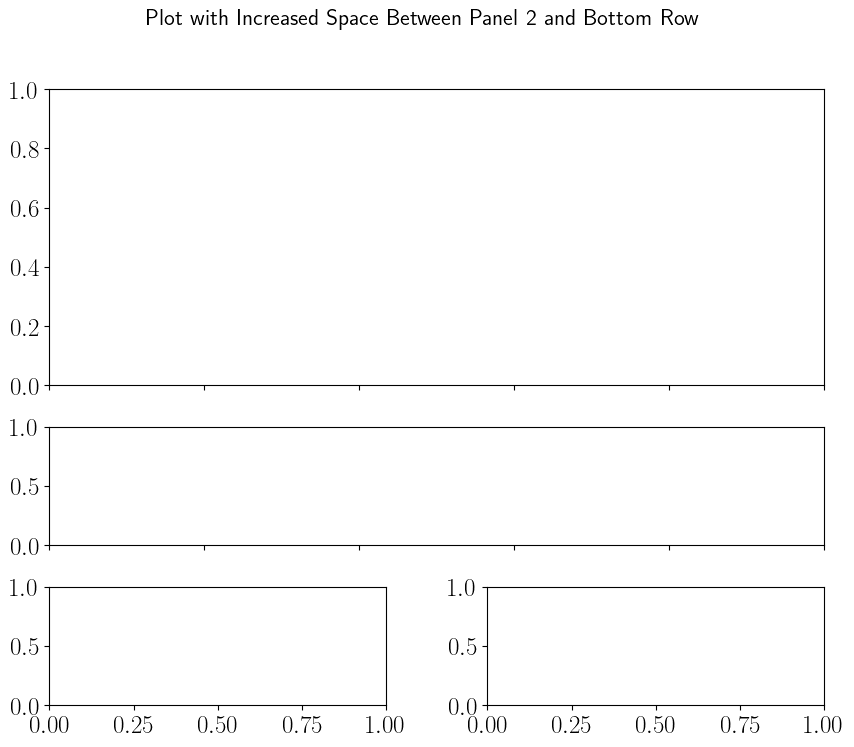

In [14]:
import matplotlib.pyplot as plt

def prepare_plot(figsize, height_ratios=[3, 1.2, 1.2], gap1=0.25, gap2=0.6):
    """
    Creates a plot layout with a main panel, a second panel, and a bottom row 
    split into two panels. Allows for custom spacing between them.
    
    Args:
        figsize (tuple): The figure size.
        height_ratios (list): The relative heights of the three main plot areas.
        gap1 (float): The relative height of the space between the top and middle panels.
        gap2 (float): The relative height of the space between the middle and bottom panels.
    """
    fig = plt.figure(figsize=figsize)

    # Main GridSpec: Now 5 rows to accommodate a second spacer
    # The layout is [plot, spacer, plot, spacer, plot]
    gs = fig.add_gridspec(
        5, 1,  # Changed from 4 to 5 rows
        hspace=0.05, wspace=0,
        # Updated height_ratios to include the new gap2
        height_ratios=[height_ratios[0], gap1, height_ratios[1], gap2, height_ratios[2]],
        width_ratios=[1]
    )

    # Top panel (remains in the first row, index 0)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Second panel (remains in the third row, index 2)
    ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)

    # Bottom panel split into 2 columns using nested GridSpec
    # This is now attached to the FIFTH row (index 4) of the main gridspec
    gs_bottom = gs[4, 0].subgridspec(1, 2, wspace=0.3, hspace=0.51)
    ax3_left = fig.add_subplot(gs_bottom[0, 0], sharey=None)
    ax3_right = fig.add_subplot(gs_bottom[0, 1], sharey=ax3_left)

    # Add labels to easily identify axes
    # ax1.set_ylabel("ax1", fontsize=14)
    # ax2.set_ylabel("ax2", fontsize=14)
    # ax3_left.set_xlabel("ax3_left", fontsize=14)
    # ax3_right.set_xlabel("ax3_right", fontsize=14)

    # Hide tick labels on upper plots for clarity
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    return [ax1, ax2, ax3_left, ax3_right]

# --- Example Usage ---
figsize = (10, 8)

# You can now control the new gap with the `gap2` parameter
axes_outer = prepare_plot(figsize, gap1=0.3, gap2=0.3)

# ax1, ax2, ax3_left, ax3_right = axes_outer # This line is correct, just renamed for clarity

plt.suptitle("Plot with Increased Space Between Panel 2 and Bottom Row", fontsize=16)
plt.show()

In [15]:
def dist_matrix(ax1):
    # (optional) hide ax1's own frame since it will host a grid of axes
    ax1.set_axis_off()

    # --- START of your "ax1" plotting code adapted to nest inside ax1 ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import matplotlib as mpl

    
    # Assume filtered_data2, data, data2 defined as in your environment
    vars_list = list(filtered_data2)
    vars_list_key = list(filtered_data2.keys())
    n = len(vars_list)
    print(n)

    fig = ax1.figure  # <-- use the existing figure

    # Make a nested GridSpec INSIDE ax1
    subgs = ax1.get_subplotspec().subgridspec(
        nrows=n, ncols=n, hspace=0.5, wspace=0.5
    )

    # Build the inner axes array
    axes = np.empty((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            axes[i, j] = fig.add_subplot(subgs[i, j])

    # --- now your plotting logic can stay basically the same ---
    # custom_labels = [
    #     r"$\mathrm{d}$",
    #     r"$\mathrm{t}_\mathrm{c}$ ",
    #     r"$\mathrm{L}_{\mathrm{x,L}}$ ",
    #     r"$\mathrm{L}_{\mathrm{x,R}}$ ",
    #     r"$\mathrm{F}_{\mathrm{z,L}}$ ",
    #     r"$\mathrm{F}_{\mathrm{z,R}}$ ",
    #     r"$\mathrm{h}_\mathrm{B}$ "
    # ]

    nbin = 20
    bin_edge_vars = [ np.linspace(50, 120, nbin),
                    np.linspace(0, 300, nbin),
                    np.linspace(0.5, 1.6, nbin),
                    np.linspace(0.5, 1.6, nbin),
                    np.linspace(-1.8e-1, -1.1e-1, nbin),
                    np.linspace(-1.8e-1, -1.1e-1, nbin),
                    np.linspace(0., 2, nbin) ]

    scales = [1, 1, 1e6, 1e6, 1e-6, 1e-6, 1e3]

    last_contour = None
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]

            if j > i:
                ax.axis('off')  # upper triangle off
                continue

            if i == j:
                ax.axis('off')
                # your diagonal stuff could go here if you re-enable it
                continue

            # lower triangle kde
            try:
                last_contour = sns.kdeplot(
                    data=data, x=vars_list[j], y=vars_list[i],
                    fill=True, ax=ax, levels=50, alpha=0.99
                )
                last_contour = sns.kdeplot(
                    data=data2, x=vars_list[j], y=vars_list[i],
                    fill=True, ax=ax, levels=50, alpha=0.99
                )
            except Exception:
                ax.text(0.5, 0.5, "Err", ha='center', va='center')

            # labels / ticks
            if j == 0:
                ax.set_ylabel(custom_labels[i], labelpad=10)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

            if i == n - 1:
                ax.set_xlabel(custom_labels[j], labelpad=10)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_xlabel('')
                ax.set_xticks([])
                ax.set_yticks([])

    # style spines for lower triangle only
    for i in range(n):
        for j in range(n):
            if j > i: 
                continue
            ax = axes[i, j]
            for loc in ['left', 'bottom']:
                ax.spines[loc].set_visible(True)
                ax.spines[loc].set_linewidth(1.0)
            for loc in ['top', 'right']:
                ax.spines[loc].set_visible(False)

    # global corner labels (still pointing at inner axes)
    axes[0, 0].set_ylabel(custom_labels[0], labelpad=0)
    axes[n-1, n-1].set_xlabel(custom_labels[-1], labelpad=0)

    # legend (pick any inner axes to host)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="royalblue", edgecolor='royalblue', label=r"$\rho = 1 \times 10^{10}$ (cm$^{-2}$)"),
        Patch(facecolor="red", edgecolor='r', label=r"$\rho = 5 \times 10^{9}$ (cm$^{-2}$)")
    ]
    #axes[2, 5].legend(handles=legend_elements, loc="upper right", fontsize =16)

    # optional: colorbar example (if you re-enable it)
    # if last_contour and last_contour.collections:
    #     fig.colorbar(last_contour.collections[0],
    #                  ax=axes.ravel().tolist(),
    #                  orientation='vertical',
    #                  fraction=0.02, pad=0.01, location='right')

    # panel label on the inner grid
    # axes[0, 0].text(-0.02, 0.8, r"a)", transform=axes[0, 0].transAxes)

    # DO NOT call plt.subplots_adjust() here (would affect the whole figure).
    # Let the outer hspace=0 in prepare_plot control panel spacing,
    # and the inner subgridspec's hspace/wspace control the small multiples.
    # plt.show()
    # --- END adapted block ---


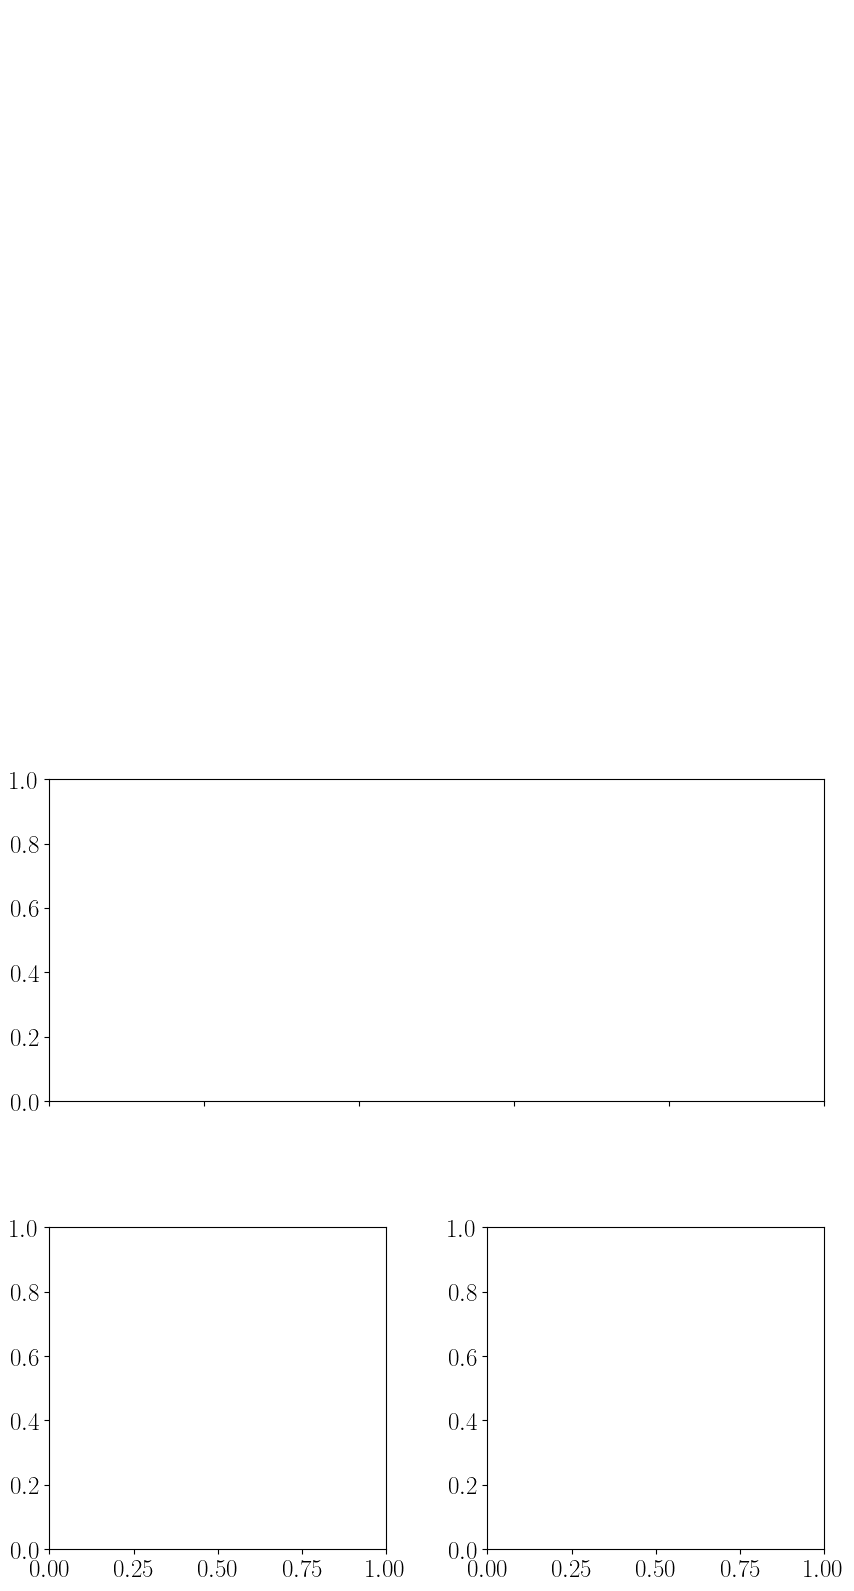

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",
})
# mpl.style.use("seaborn")
# mpl.rcParams['font.size'] = 18
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",
})

# mpl.rcParams.update({
#         'font.size': SMALL_SIZE,
#         'axes.labelsize': SMALL_SIZE,
#         'xtick.labelsize': SMALL_SIZE,
#         'ytick.labelsize': SMALL_SIZE,
#         'legend.fontsize': 8,
#         'axes.titlesize': BIGGER_SIZE
#     })

import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from scipy.stats import norm, kstest

selected_keys = ["d", "tcs", "Lxavg", "dLx", "Favg","dF", "eps"]
# selected_keys = ["d", "tcs", "Favg","dF", "eps"]
# selected_keys = ["axLs", "axRs", "d", "Bhs", "FzLs", "FzRs" ]

custom_labels = [
        r"$\mathrm{d}$",
        r"$\mathrm{t}_\mathrm{c}$ ",
        r"$\langle \mathrm{L}_{\mathrm{x}} \rangle$ ",
        r"$\Delta \mathrm{L}_{\mathrm{x}}$ ",
        r"$\langle \mathrm{F}_{\mathrm{z}} \rangle$ ",
        r"$\Delta \mathrm{F}_{\mathrm{z}}$ ",
        r"$\mathrm{\epsilon}$ ",
        # r"$\langle \mathrm{E} \rangle $",
    ]

import pandas as pd



filtered_data = {key: data[key] for key in selected_keys if key in data}
filtered_data2 = {key: data2[key] for key in selected_keys if key in data2}

## data2: rho = 10^10 cm-2
df = pd.DataFrame(filtered_data2)

# --- outer layout you already have ---
axes_outer = prepare_plot(figsize=(10, 20), height_ratios=[2, 1, 1], gap1=0.3, gap2=0.3)
ax1, ax2, ax3, ax3_right = axes_outer
ax1.set_axis_off()

# dist_matrix(ax1)


In [17]:
# pcs = get_PCs(df, df.keys() )


In [18]:
len(df)












500

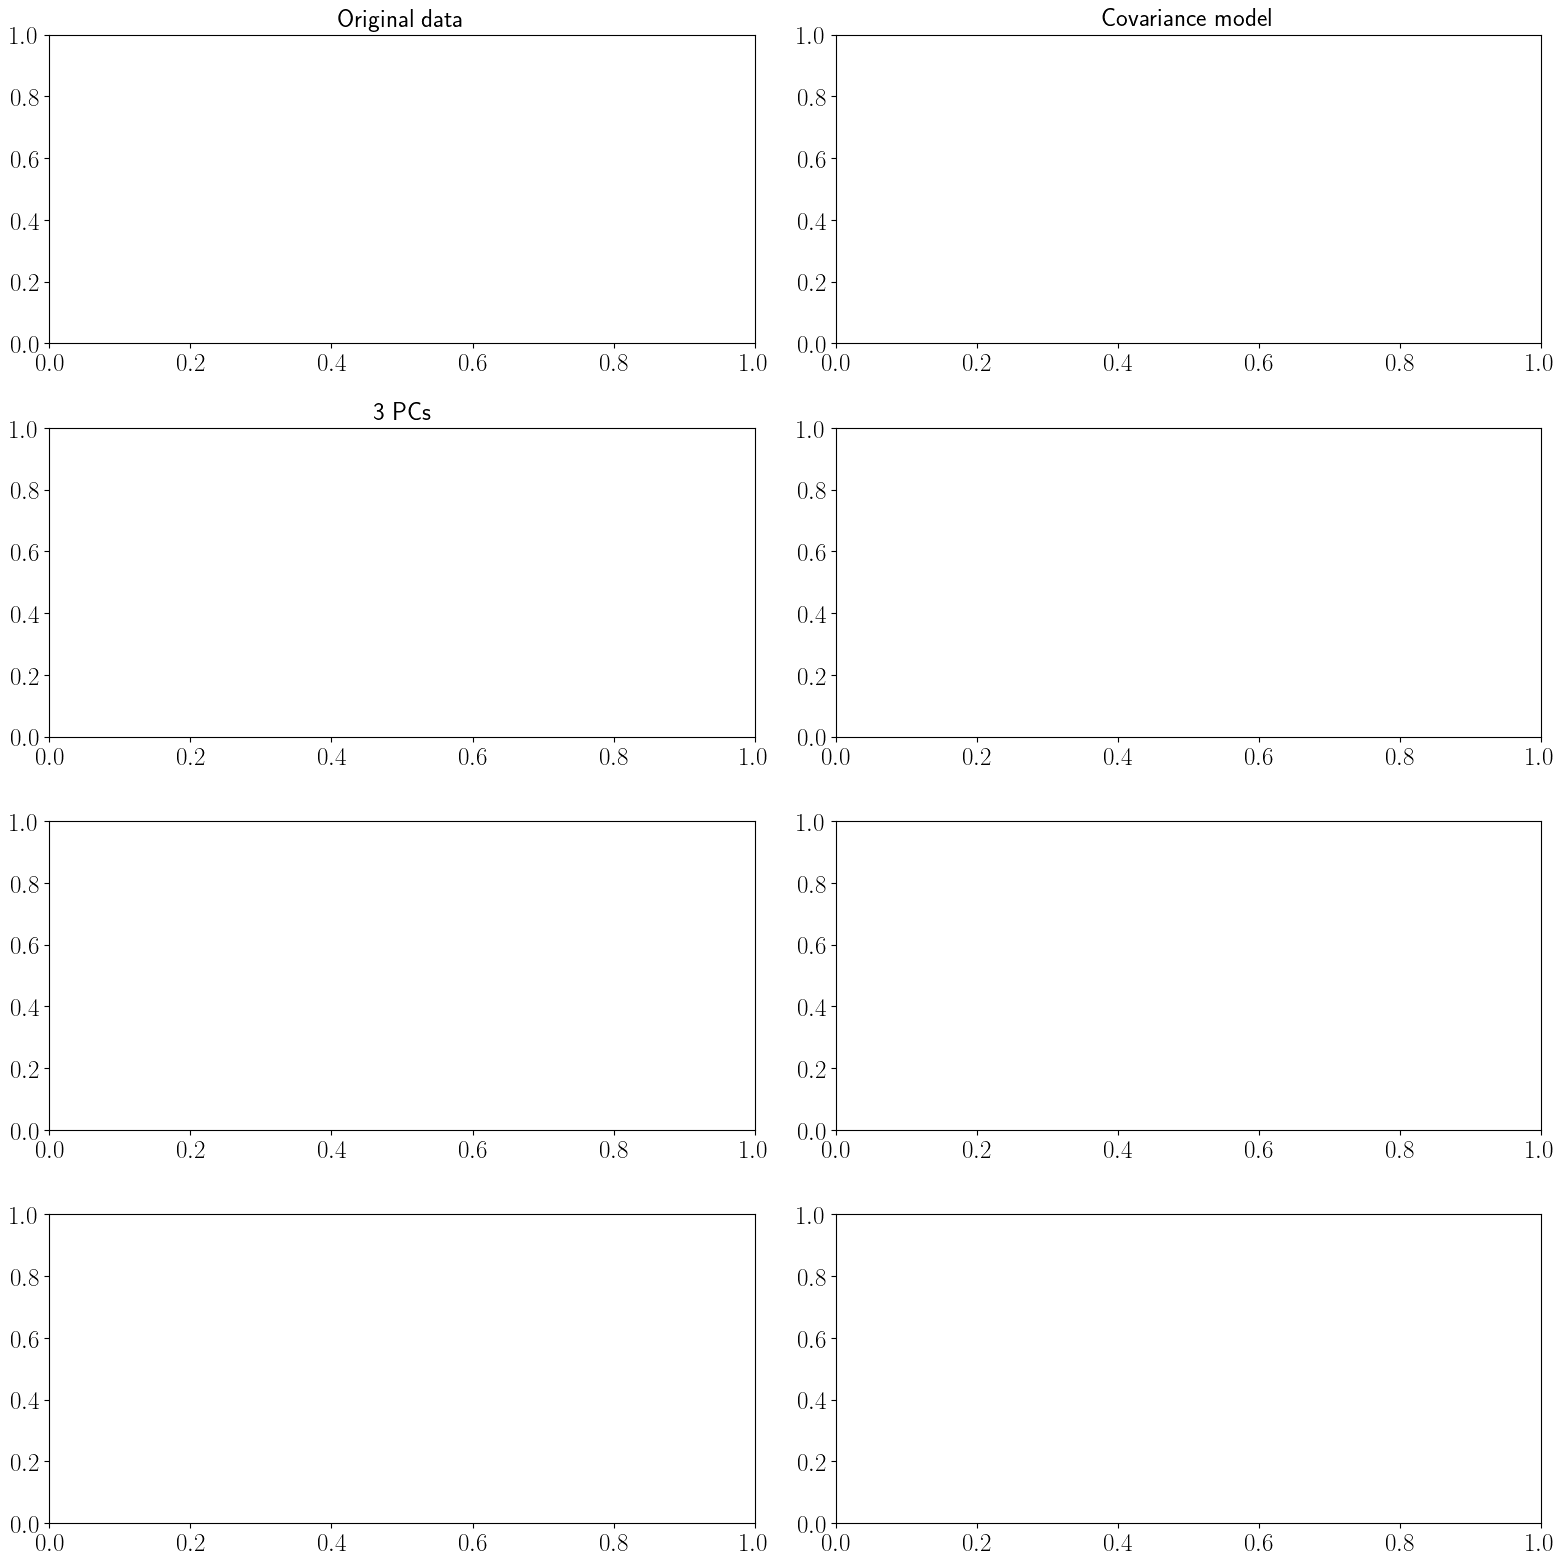

In [19]:
def dist_matrix(ax1):
    # (optional) hide ax1's own frame since it will host a grid of axes
    ax1.set_axis_off()

    # --- START of your "ax1" plotting code adapted to nest inside ax1 ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import matplotlib as mpl

    
    # Assume filtered_data2, data, data2 defined as in your environment
    vars_list = list(filtered_data2)
    vars_list_key = list(filtered_data2.keys())
    n = len(vars_list)
    print(n)

    fig = ax1.figure  # <-- use the existing figure

    # Make a nested GridSpec INSIDE ax1
    subgs = ax1.get_subplotspec().subgridspec(
        nrows=n, ncols=n, hspace=0.5, wspace=0.5
    )

    # Build the inner axes array
    axes = np.empty((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            axes[i, j] = fig.add_subplot(subgs[i, j])

    # --- now your plotting logic can stay basically the same ---
    # custom_labels = [
    #     r"$\mathrm{d}$",
    #     r"$\mathrm{t}_\mathrm{c}$ ",
    #     r"$\mathrm{L}_{\mathrm{x,L}}$ ",
    #     r"$\mathrm{L}_{\mathrm{x,R}}$ ",
    #     r"$\mathrm{F}_{\mathrm{z,L}}$ ",
    #     r"$\mathrm{F}_{\mathrm{z,R}}$ ",
    #     r"$\mathrm{h}_\mathrm{B}$ "
    # ]

    nbin = 20
    bin_edge_vars = [ np.linspace(50, 120, nbin),
                    np.linspace(0, 300, nbin),
                    np.linspace(0.5, 1.6, nbin),
                    np.linspace(0.5, 1.6, nbin),
                    np.linspace(-1.8e-1, -1.1e-1, nbin),
                    np.linspace(-1.8e-1, -1.1e-1, nbin),
                    np.linspace(0., 2, nbin) ]

    scales = [1, 1, 1e6, 1e6, 1e-6, 1e-6, 1e3]

    last_contour = None
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]

            if j > i:
                ax.axis('off')  # upper triangle off
                continue

            if i == j:
                ax.axis('off')
                # your diagonal stuff could go here if you re-enable it
                continue

            # lower triangle kde
            try:
                last_contour = sns.kdeplot(
                    data=data, x=vars_list[j], y=vars_list[i],
                    fill=True, ax=ax, levels=50, alpha=0.99
                )
                last_contour = sns.kdeplot(
                    data=data2, x=vars_list[j], y=vars_list[i],
                    fill=True, ax=ax, levels=50, alpha=0.99
                )
            except Exception:
                ax.text(0.5, 0.5, "Err", ha='center', va='center')

            # labels / ticks
            if j == 0:
                ax.set_ylabel(custom_labels[i], labelpad=10)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

            if i == n - 1:
                ax.set_xlabel(custom_labels[j], labelpad=10)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_xlabel('')
                ax.set_xticks([])
                ax.set_yticks([])

    # style spines for lower triangle only
    for i in range(n):
        for j in range(n):
            if j > i: 
                continue
            ax = axes[i, j]
            for loc in ['left', 'bottom']:
                ax.spines[loc].set_visible(True)
                ax.spines[loc].set_linewidth(1.0)
            for loc in ['top', 'right']:
                ax.spines[loc].set_visible(False)

    # global corner labels (still pointing at inner axes)
    axes[0, 0].set_ylabel(custom_labels[0], labelpad=0)
    axes[n-1, n-1].set_xlabel(custom_labels[-1], labelpad=0)

    # legend (pick any inner axes to host)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="royalblue", edgecolor='royalblue', label=r"$\rho = 1 \times 10^{10}$ (cm$^{-2}$)"),
        Patch(facecolor="red", edgecolor='r', label=r"$\rho = 5 \times 10^{9}$ (cm$^{-2}$)")
    ]
    #axes[2, 5].legend(handles=legend_elements, loc="upper right", fontsize =16)

    # optional: colorbar example (if you re-enable it)
    # if last_contour and last_contour.collections:
    #     fig.colorbar(last_contour.collections[0],
    #                  ax=axes.ravel().tolist(),
    #                  orientation='vertical',
    #                  fraction=0.02, pad=0.01, location='right')

    # panel label on the inner grid
    # axes[0, 0].text(-0.02, 0.8, r"a)", transform=axes[0, 0].transAxes)

    # DO NOT call plt.subplots_adjust() here (would affect the whole figure).
    # Let the outer hspace=0 in prepare_plot control panel spacing,
    # and the inner subgridspec's hspace/wspace control the small multiples.
    # plt.show()
    # --- END adapted block ---



n_samples = 500
cov_matrix = df.cov()


data_model_cov = np.random.multivariate_normal(np.zeros(len(df.keys())), cov_matrix, n_samples)
data_model_cov = pd.DataFrame(data_model_cov, columns=df.keys())

from sklearn.decomposition import PCA

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Fit PCA
pca = PCA()
pca.fit(df_scaled)

# Project data onto first PC, first 2 PCs, and first 3 PCs

pcs_3 = pca.transform(df_scaled)[:, :3]


# For each case, generate new data in PC space, then inverse transform to original space
def generate_from_pcs(pcs_proj, n_pcs, n_samples, pca, scaler):
    # Estimate mean and std in PC space
    mean = np.mean(pcs_proj, axis=0)
    std = np.std(pcs_proj, axis=0)
    # Generate new samples in PC space
    pcs_samples = np.random.normal(loc=mean, scale=std, size=(n_samples, n_pcs))
    # Pad with zeros for remaining PCs
    pcs_full = np.zeros((n_samples, pca.components_.shape[0]))
    pcs_full[:, :n_pcs] = pcs_samples
    # Inverse transform: from PC space to standardized feature space
    data_std = pca.inverse_transform(pcs_full)
    # Inverse standardization: from standardized to original feature space
    data_orig = scaler.inverse_transform(data_std)
    return pd.DataFrame(data_orig, columns=df.columns)

# Generate datasets
data_from_pc3 = generate_from_pcs(pcs_3, 3, n_samples, pca, scaler)


fig, axs = plt.subplots(4, 2, figsize=(16, 16))

# For each dataset, call dist_matrix on a subplot axis
# You may want to select a subset of columns for clarity, e.g. the first 7 columns
cols_to_plot = df.columns[:7]

# Prepare data for each plot
datasets = [
    (df[cols_to_plot], "Original data"),
    (data_model_cov[cols_to_plot], "Covariance model"),
    (data_from_pc3[cols_to_plot], "3 PCs")
]

for ax, (data, title) in zip(axs.ravel(), datasets):
    # The dist_matrix function expects variables named filtered_data2, data, data2, custom_labels
    filtered_data2 = data
    # For demonstration, use the same data for both data and data2
    data = filtered_data2
    data2 = filtered_data2
    custom_labels = [col for col in cols_to_plot]
    # dist_matrix(ax)
    ax.set_title(title, fontsize=18)

plt.tight_layout()
plt.show()













In [20]:
cols_to_plot

Index(['d', 'tcs', 'Lxavg', 'dLx', 'Favg', 'dF', 'eps'], dtype='object')

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

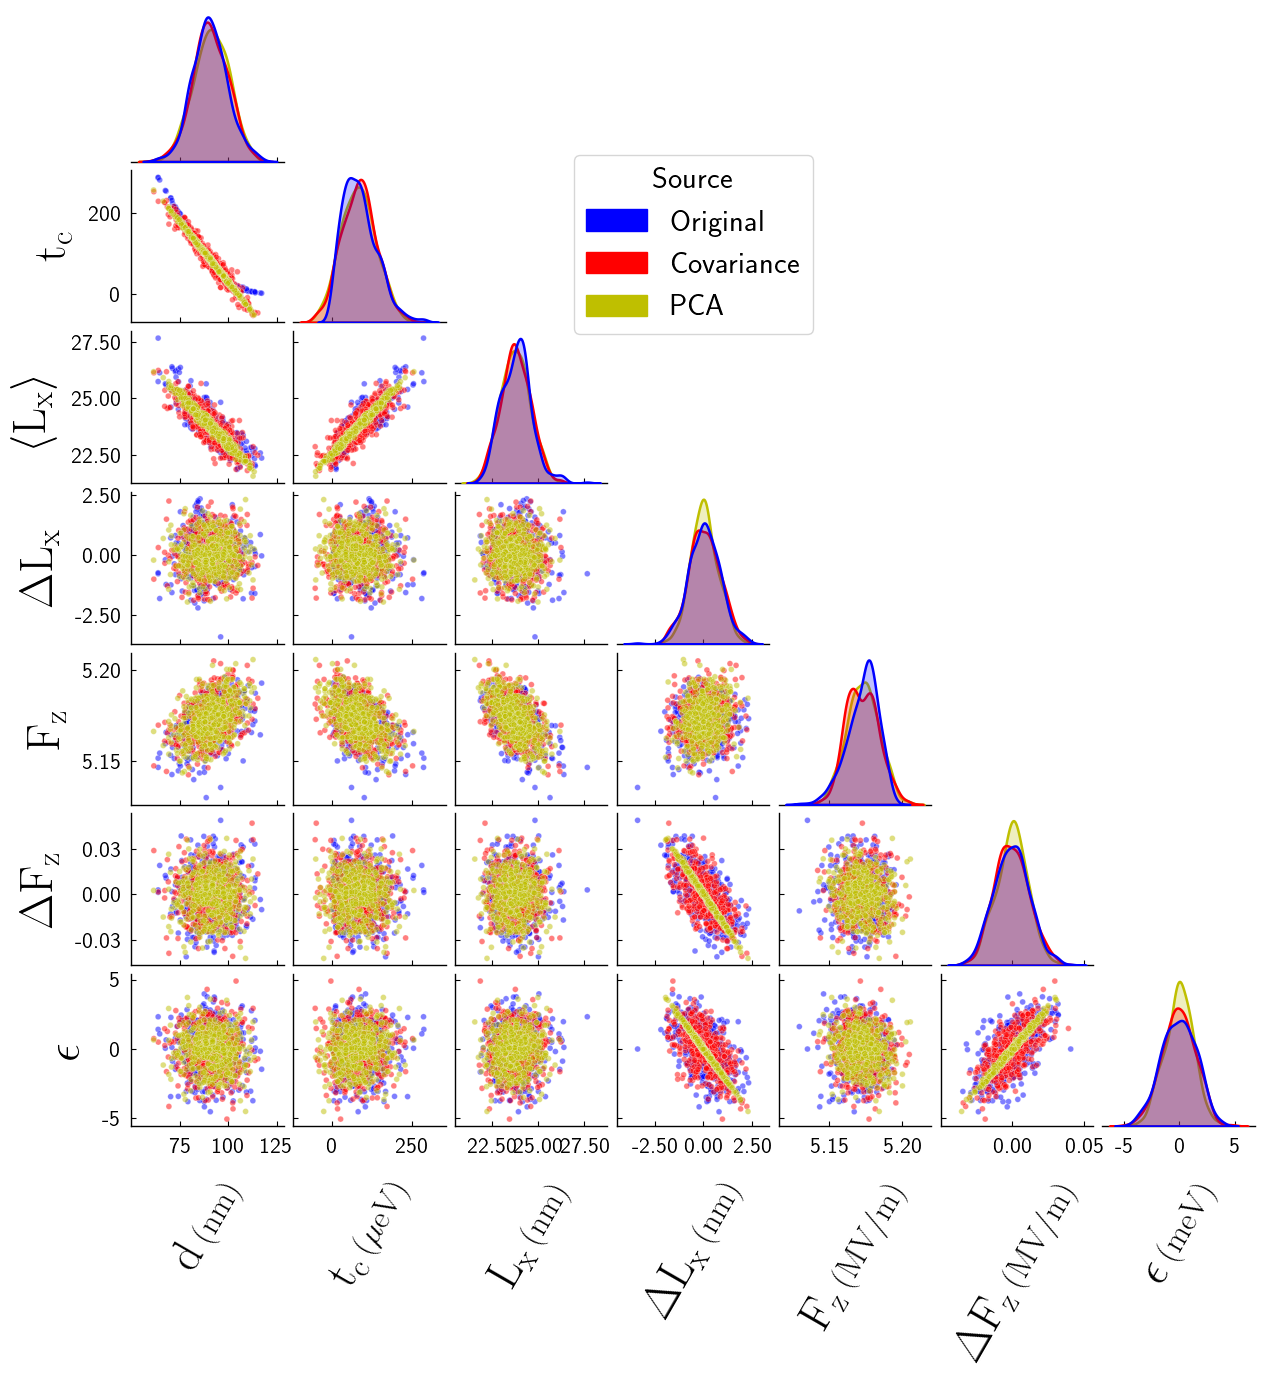

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# --- 4. Generate the Triangular Plot with Improved Fonts and LaTeX Labels ---

import itertools


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # "font.sans-serif": "Helvetica",
})
# mpl.style.use("seaborn")
# mpl.rcParams['font.size'] = 18
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     # "font.sans-serif": "Helvetica",
# })

latex_labels = { 'xLs': r'$\mathrm{x}_\mathrm{L}$',
    'yLs': r'$\mathrm{y}_\mathrm{L}$',
    'axLs': r'$\alpha_{\mathrm{x},\mathrm{L}}$',
    'ayLs': r'$\alpha_{\mathrm{y},\mathrm{L}}$',
    'ELs': r'$\mathrm{E}_\mathrm{L}$',
    'eps_Ls': r'$\epsilon_\mathrm{L}$',
    'xRs': r'$\mathrm{x}_\mathrm{R}$',
    'yRs': r'$\mathrm{y}_\mathrm{R}$',
    'axRs': r'$\alpha_{\mathrm{x},\mathrm{R}}$',
    'ayRs': r'$\alpha_{\mathrm{y},\mathrm{R}}$',
    'ERs': r'$\mathrm{E}_\mathrm{R}$',
    'eps_Rs': r'$\epsilon_\mathrm{R}$', 
    'tcs': r'$\mathrm{t}_\mathrm{c}$ ', 
    'Eavgs': r'$\langle \mathrm{E} \rangle$',
    'V_acs': r'$\mathrm{V}_{\mathrm{ac}}$',
    'd': r'$\mathrm{d}$ (nm)',
    'EBs': r'$\mathrm{E}_\mathrm{B}$',
    'Bhs': r'$\mathrm{B}_\mathrm{h}$ ',
    'FxLs': r'$\mathrm{F}_{\mathrm{x},\mathrm{L}}$',
    'FyLs': r'$\mathrm{F}_{\mathrm{y},\mathrm{L}}$',
    'FzLs': r'$\mathrm{F}_{\mathrm{z},\mathrm{L}}$', 
    'FxRs': r'$\mathrm{F}_{\mathrm{x},\mathrm{R}}$', 
    'FyRs': r'$\mathrm{F}_{\mathrm{y},\mathrm{R}}$',
    'FzRs': r'$\mathrm{F}_{\mathrm{z},\mathrm{R}}$', 
    'Lxavg': r'$\langle \mathrm{L}_\mathrm{x} \rangle$',
    'dLx': r'$\Delta \mathrm{L}_\mathrm{x}$ ', 
    'Lyavg': r'$ \mathrm{L}_\mathrm{y} $',
    'dLy': r'$\Delta \mathrm{L}_\mathrm{y}$', 
    'Favg': r'$ \mathrm{F}_\mathrm{z} $', 
    'dF': r'$\Delta \mathrm{F}_\mathrm{z}$',
    'eps': r'$\epsilon$ ' }

# Define LaTeX labels for the variables (edit as needed for your variables)
latex_labels_small_units = {
    'xLs':     r'$\mathrm{x}_\mathrm{L}$',
    'yLs':     r'$\mathrm{y}_\mathrm{L}$',
    'axLs':    r'$\alpha_{\mathrm{x},\mathrm{L}}$',
    'ayLs':    r'$\alpha_{\mathrm{y},\mathrm{L}}$',
    'ELs':     r'$\mathrm{E}_\mathrm{L}$',
    'eps_Ls':  r'$\epsilon_\mathrm{L}$',

    'xRs':     r'$\mathrm{x}_\mathrm{R}$',
    'yRs':     r'$\mathrm{y}_\mathrm{R}$',
    'axRs':    r'$\alpha_{\mathrm{x},\mathrm{R}}$',
    'ayRs':    r'$\alpha_{\mathrm{y},\mathrm{R}}$',
    'ERs':     r'$\mathrm{E}_\mathrm{R}$',
    'eps_Rs':  r'$\epsilon_\mathrm{R}$',

    'tcs':     r'$\mathrm{t}_\mathrm{c}\,{\scriptstyle (\mu\mathrm{eV})}$',
    'Eavgs':   r'$\langle \mathrm{E} \rangle$',
    'V_acs':   r'$\mathrm{V}_{\mathrm{ac}}$',
    'd':       r'$\mathrm{d}\,{\scriptstyle (\mathrm{nm})}$',
    'EBs':     r'$\mathrm{E}_\mathrm{B}$',
    'Bhs':     r'$\mathrm{B}_\mathrm{h}\,{\scriptstyle (\mathrm{meV})}$',

    'FxLs':    r'$\mathrm{F}_{\mathrm{x},\mathrm{L}}$',
    'FyLs':    r'$\mathrm{F}_{\mathrm{y},\mathrm{L}}$',
    'FzLs':    r'$\mathrm{F}_{\mathrm{z},\mathrm{L}}$',

    'FxRs':    r'$\mathrm{F}_{\mathrm{x},\mathrm{R}}$',
    'FyRs':    r'$\mathrm{F}_{\mathrm{y},\mathrm{R}}$',
    'FzRs':    r'$\mathrm{F}_{\mathrm{z},\mathrm{R}}$',

    'Lxavg':   r'$ \mathrm{L}_\mathrm{x}\,{\scriptstyle (\mathrm{nm})}$',
    'dLx':     r'$\Delta \mathrm{L}_\mathrm{x}\,{\scriptstyle (\mathrm{nm})}$',
    'Lyavg':   r'$\langle \mathrm{L}_\mathrm{y} \rangle$',
    'dLy':     r'$\Delta \mathrm{L}_\mathrm{y}$',
    'Favg':    r'$ \mathrm{F}_\mathrm{z} \,{\scriptstyle (\mathrm{MV}/\mathrm{m})}$',
    'dF':      r'$\Delta \mathrm{F}_\mathrm{z}\,{\scriptstyle (\mathrm{MV}/\mathrm{m})}$',

    'eps':     r'$\epsilon\,{\scriptstyle (\mathrm{meV})}$'
}



# Use the same cols_to_plot as above
plot_cols = list(cols_to_plot)
plot_labels = [latex_labels_small_units.get(col, col) for col in plot_cols]
plot_ylabels = [latex_labels.get(col, col) for col in plot_cols]


# Set font sizes for publication
plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 34,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 28,
    "figure.titlesize": 24,
    "axes.labelpad": 10,
    "xtick.major.pad": 8,
    "ytick.major.pad": 8,
    "axes.linewidth": 1.,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "text.usetex": True,  # Set to True if you want to use LaTeX for all text
})



# --- 2. Data Generation (from your code) ---
n_samples = 500
# Using the first 4 columns for a clearer, less cluttered plot
#cols_to_plot = df.columns[:4] 
df_subset = df[cols_to_plot].copy() # Create a copy to avoid SettingWithCopyWarning

# a) Covariance model data
cov_matrix = df_subset.cov()
data_model_cov = np.random.multivariate_normal(np.zeros(len(df_subset.keys())), cov_matrix, n_samples)
data_model_cov = pd.DataFrame(data_model_cov, columns=df_subset.keys())

# Add the mean of df_subset to the covariance model data
data_model_cov += df_subset.mean().values



# b) PCA model data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_subset)
pca = PCA()
pca.fit(df_scaled)
# Using the first 3 PCs as in your example
pcs_3 = pca.transform(df_scaled)[:, :3]
pcs_2 = pca.transform(df_scaled)[:, :2]

def generate_from_pcs(pcs_proj, n_pcs, n_samples, pca, scaler, columns):
    """Generates data by sampling in PC space and inverse transforming."""
    mean = np.mean(pcs_proj, axis=0)
    std = np.std(pcs_proj, axis=0)
    pcs_samples = np.random.normal(loc=mean, scale=std, size=(n_samples, n_pcs))
    pcs_full = np.zeros((n_samples, pca.components_.shape[0]))
    pcs_full[:, :n_pcs] = pcs_samples
    data_std = pca.inverse_transform(pcs_full)
    data_orig = scaler.inverse_transform(data_std)
    return pd.DataFrame(data_orig, columns=columns)

data_from_pc3 = generate_from_pcs(pcs_3, 3, n_samples, pca, scaler, df_subset.columns)
data_from_pc2 = generate_from_pcs(pcs_2, 2, n_samples, pca, scaler, df_subset.columns)



# --- 3. Combine Data for Plotting ---
# Add a 'source' column to identify each dataset
df_subset['source'] = 'Original'
data_model_cov['source'] = 'Covariance'
data_from_pc3['source'] = 'PCA'

# Concatenate the three dataframes into a single one
combined_df = pd.concat([df_subset, data_model_cov, data_from_pc3], ignore_index=True)

# --- 4. Generate the Triangular Plot ---
# Prepare the pairplot
# g = sns.pairplot(
#     combined_df,
#     vars=plot_cols,
#     hue="source",
#     palette="Set1",
#     plot_kws={'alpha': 0.5, 's': 18},
#     diag_kws={'fill': True, 'alpha': 0.5},
#     corner=True,
#     height=3.2,
#     aspect=1
# )


"""2nd version"""

palette = {
    "Original":   "b",  # blue
    "Covariance": "r",  # red
    "PCA":        "y",  # green
}

# g = sns.pairplot(
#     combined_df,
#     vars=plot_cols,
#     hue="source",
#     hue_order=["Original", "Covariance", "PCA"],
#     palette=palette,              # your custom colors
#     kind="scatter",               # off-diagonal
#     diag_kind="kde",             # <- histogram on diagonal, smooth line: "kde"
#     plot_kws=dict(alpha=0.5, s=18),
#     diag_kws=dict(
#         bins=30,
#         element="bars",           # step outline; use "bars" for filled bars, ""
#         multiple="layer",         # overlay by hue
#         # stat="density",           # normalize to compare shapes
#         common_norm=False,
#         alpha=0.5
#     ),
#     corner=True,
#     height=3.2,
#     aspect=1
# )

g = sns.pairplot(
    combined_df,
    vars=plot_cols,
    hue="source",
    hue_order=["Original", "Covariance", "PCA"],
    palette=palette,
    kind="scatter",
    diag_kind="kde",                 # <- smooth line on the diagonal
    plot_kws=dict(alpha=0.5, s=18),
    diag_kws=dict(
        fill=True,                  # line only (no fill)
        bw_adjust=1.0,               # smoothness (lower=wigglier, higher=smoother)
        linewidth=1.8,
        common_norm=False            # don’t normalize across groups
    ),
    corner=True,
    height=3.2,
    aspect=1
)

# Option A: fixed inches
g.fig.set_size_inches(14, 12)   # (width, height) in inches


xlabels = plot_labels
ylabels = plot_ylabels if 'plot_ylabels' in globals() and plot_ylabels else plot_labels

n = len(xlabels)

# Diagonal: set both x/y to that variable's labels
for i, (xlab, ylab) in enumerate(zip(xlabels, ylabels)):
    ax = g.axes[i, i] if i < g.axes.shape[0] else None
    if ax is not None:
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)

# Lower triangle: row i, col j (corner=True → upper triangle is None)
for i in range(n):
    for j in range(i):
        ax = g.axes[i, j]
        if ax is not None:
            ax.set_xlabel(xlabels[j])  # x comes from column variable
            ax.set_ylabel(ylabels[i])  # y comes from row variable
            

# Remove redundant y-labels and x-labels for clarity
for i, j in itertools.product(range(len(plot_cols)), repeat=2):
    ax = g.axes[i, j] if g.axes[i, j] is not None else None
    if ax:
        if j != 0:
            ax.set_ylabel("")
        if i != len(plot_cols) - 1:
            ax.set_xlabel("")
# Fix legend issue: Only add legend if legend_ax is not None

# Move the legend to the empty part of the triangle (top right)
# Find the top-right-most axis (first row, last column used)
for i in range(len(plot_cols)):
    for j in range(len(plot_cols)):
        if i == 0 and j == len(plot_cols) - 1:
            legend_ax = g.axes[i, j]
            break

handles, labels = g._legend_data.values(), g._legend_data.keys()
if legend_ax is not None:
    handles, labels = g._legend_data.values(), g._legend_data.keys()
    legend = legend_ax.legend(
        handles=list(handles),
        labels=list(labels),
        title="Source",
        bbox_to_anchor=(-5, 1.1),
        frameon=True,
        # fontsize=30,
        # title_fontsize=40
    )
    if hasattr(g, "_legend") and g._legend is not None:
        g._legend.remove()  # Remove the default legend


g._legend.remove()  # Remove the default legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="b", edgecolor='b',
          label="Original"),
    Patch(facecolor="r", edgecolor='r',
          label="Covariance"),
    Patch(facecolor="y", edgecolor='y',
          label="PCA"),
]

ax = g.axes[3, 3]

# 1) Centered above this subplot
ax.legend(
    handles=legend_elements, title="Source", frameon=True,
    loc="upper center", bbox_to_anchor=(0.5, 3.22), borderaxespad=0.0, fontsize=22, title_fontsize=22
)


import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

def ticks_have_decimals(ticks):
    ticks = np.asarray([t for t in ticks if np.isfinite(t)])
    if ticks.size == 0:
        return False
    return np.any(~np.isclose(ticks, np.round(ticks)))

def make_formatter(ndec, use_math):
    if use_math:
        return FuncFormatter(lambda x, pos, ndec=ndec: rf"\mathdefault{{{x:.{ndec}f}}}")
    else:
        return FuncFormatter(lambda x, pos, ndec=ndec: f"{x:.{ndec}f}")

use_math = mpl.rcParams.get("text.usetex", False)

# run this after creating `g` (before tight_layout / show)
for i in range(len(plot_cols)):
    for j in range(len(plot_cols)):
        ax = g.axes[i, j]
        if ax is None:
            continue

        # X axis
        x_has_dec = ticks_have_decimals(ax.get_xticks())
        ax.xaxis.set_major_formatter(
            make_formatter(2 if x_has_dec else 0, use_math)
        )

        # Y axis
        y_has_dec = ticks_have_decimals(ax.get_yticks())
        ax.yaxis.set_majorFormatter = ax.yaxis.set_major_formatter  # just alias
        ax.yaxis.set_major_formatter(
            make_formatter(2 if y_has_dec else 0, use_math)
        )
# rotate X **axis labels** (the xlabel text you set)
for j in range(len(plot_cols)):
    ax = g.axes[len(plot_cols)-1, j]
    if ax is None:
        continue
    ax.xaxis.label.set_rotation(60)     # rotate the xlabel
    ax.xaxis.set_label_coords(0.5, -0.3)  # nudge down if needed

plt.tight_layout()
# plt.show()

plt.savefig(figure_root+"reconstructed.png", dpi=100, bbox_inches="tight")